# Модель прогнозирования стоимости жилья для агентства недвижимости

In [173]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import category_encoders as ce

# 1. Предварительная обработка данных

In [174]:
# загрузка данных в датафрейм
data = pd.read_csv("./data/data.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [176]:
# определяем наличие дубликатов
data_duplicated = data.duplicated()
data_duplicated.sum()

50

In [177]:
# удаляем полные дубликаты
data = data.drop_duplicates(ignore_index=True)
data.shape[0]

377135

In [178]:
# смотрим пропуски
data.isna().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Априори прикидываем важность признаков, которым следует уделить максимум внимания:

1. Площадь жилая (sqft)
2. Количество комнат, ванных комнат (beds, baths)
3. Информация о школах (schools)
4. География и расположение (city, street, zipcode)
5. Информация о доме (homefacts, stories)

Поля Mls-Id и MlsId удаляем, так как в них слишком много пропусков и они не несут полезной информации (уникальные идентификаторы)

In [179]:
# удаляем поле
data.drop(labels=['MlsId','mls-id'], axis=1, inplace=True)

### География и расположение

In [180]:
# исследуем географию и расположение объектов, в том числе ищем дубликаты по геополям
adres_data = data[['street', 'city', 'zipcode','state']]
data.loc[adres_data.duplicated()==True].head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
549,For sale,NaN,Single Family,5398 Alcola Way S,2,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",Yes,Saint Petersburg,"[{'rating': ['2/10', '4/10', '4/10'], 'data': ...","1,617",33712,3,FL,1.0,Yes,"$280,000"
753,for sale,NaN,lot/land,5428 Closeburn Rd,NaN,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Charlotte,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","4,595 sqft",28210,5 Beds,NC,3,NaN,"$349,000"
1648,Active,NaN,Single Family Home,8 Potterville Ln,3,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Palm Coast,"[{'rating': ['5', '4', '6', '5', 'NR', 'NR', '...",2350,32164,4,FL,One,NaN,"$279,900"
2375,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,856",85387,4,AZ,NaN,NaN,"$373,990"
2643,Active,NaN,Single Family Home,2909 Otis St NE,3.5,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",NaN,Washington,"[{'rating': ['3', '3', '3', 'NR', '5', '5', 'N...",2848,20018,4,DC,3+,NaN,"$699,000"


В данных много записей, относящихся к одним и тем же объектам недвижимости (Single home). Вероятно они собраны из разных источников либо это повторные по времени объявления.
Удаление этих записей негативно сказывается на метриках модели. Оставляем их.

In [181]:
# удаляем дубликаты по комбинации адресных данных
#data = data.drop_duplicates(subset=['street', 'city', 'zipcode','state'])
#data.shape

Предварительные выводы по итогам исследования характеристик признаков:

1. Поля штат, город и зип-код априори сильно коррелирующие признаки. Оставляем один из них - зип-код.
2. Поле street содержит адрес объекта. Необходимо удалить его, так как оно является идентификатором объекта недвижимости. Использование признака приведет к утечке данных.
3. Удаляем лишние поля, оставляем зип-код

In [182]:
data['zipcode'] = data['zipcode'].apply(lambda x: x[:5]) # обрезаем лишние символы
data['zipcode'] = data['zipcode'].apply(lambda x: re.sub(r'[^0-9]', '', x)) # удаляем лишние символы
data['zipcode'].value_counts().count() # оцениваем метод кодирования

4318

Для признака zipcode подойдет метод двоичного кодирования

Вывод по итогам валидации модели: Кодировка методом двоичного кодирования признаков zip-код или city не дает прироста качества предсказания. Оставляем его в виде числового признака

In [183]:
# проверяем на наличие пустых значений
data[data['zipcode']=='']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
231264,New construction,NaN,NaN,0 N Gopher Canyon Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",NaN,,449 acres,CA,NaN,NaN,"$60,000,000"
235188,NaN,NaN,Townhouse,1744 N Dixie Hwy # 1744,3.0,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...","2,043",,3,FL,NaN,NaN,"$425,000"


In [184]:
# заполняем пустые значения данными из интернета
data.loc[235188, 'zipcode'] = 33305
data.loc[231264, 'zipcode'] = 92003
# конвертируем поле zipcode в целое
data['zipcode'] = data['zipcode'].astype('int')
# удаляем лишние поля
data = data.drop(labels=['city','state','street'], axis=1)

### Распаковка поля 'homeFacts'

In [185]:
new_features_list = list() # создаем пустой список для словарей

def homeFacts_unpack(arg): # функция распаковки поля homeFacts в словарь
    facts_dict = eval(arg)['atAGlanceFacts']
    dictionary = dict()
    for i in facts_dict:
        if i['factValue'] == '':
            dictionary[i['factLabel']] = 'none'
        else:
            dictionary[i['factLabel']] = i['factValue']
    new_features_list.append(dictionary) # добавляем словарь в список
# обрабатываем поле функцией
data['homeFacts'].apply(homeFacts_unpack)
# преобразуем список словарей в новый датафрейм
extra_data = pd.DataFrame(new_features_list)
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)
# удаляем исходное поле
data = data.drop(labels=['homeFacts'], axis=1)
# получены новые признаки
extra_data.columns

Index(['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking',
       'lotsize', 'Price/sqft'],
      dtype='object')

Получили пять новых признаков:

'Year built' - год постройки ;

'Remodeled year' - год ремонта/реновации;

'Heating' - наличие и тип отопления;

'Cooling' - наличие кондиционера;

'Parking' - паркинг;

'lotsize' - размер земельного участка;

'Price/sqft' - цена жилья за кв.фут

### Обработка полей 'Year built' и 'Remodeled year'

In [186]:
# изучаем структуру данных в поле и граничные значения признаков
data['Year built'].value_counts().sort_index().head(10)

Year built
1       2
1019    1
1057    1
1060    1
1208    1
1700    1
1703    2
1735    1
1740    1
1750    2
Name: count, dtype: int64

In [187]:
data['Year built'].value_counts().sort_index().tail(10)

Year built
2017             5179
2018             6855
2019            32168
2020             2435
2021               62
2022                8
2025                2
559990649990        2
No Data          1222
none            58729
Name: count, dtype: int64

In [188]:
# обрабатываем странные значения Year built, пропускам присваиваем NaN
data.loc[data[data['Year built']=='1019'].index, 'Year built'] = '1919'
data.loc[data[data['Year built']=='1057'].index, 'Year built'] = '1957'
data.loc[data[data['Year built']=='1060'].index, 'Year built'] = '1960'
data.loc[data[data['Year built']=='1208'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='1'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='559990649990'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='No Data'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='none'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']==''].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='0'].index, 'Year built'] = np.nan
# обрабатываем странные значения в Remodeled year, пропускам присваиваем NaN
data.loc[data[data['Remodeled year']=='1111'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']==''].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='none'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='0'].index, 'Remodeled year'] = '0'

Поле "Год постройки" имеет большое количество пропусков. Заполняем пропуски модой.

В качестве возможных вариантов дальнейшей обработки:
1. Год постройки можно взять из даты реконструкции 'Remodeled year'
2. Сравнить даты. Если дата постройки Year built больше (младше) даты реконструкции, то в качестве даты постройки устанавить дату реконструкции 'Remodeled year'

In [189]:
# Для пустых дат постройки Year built заполняем датой реконструкции
#data.loc[data.loc[data['Year built'].isna()].index , 'Year built'] = data['Remodeled year']
year_built_mode = data['Year built'].mode()[0]
# заполняем пропуски
data = data.fillna({
    'Year built': year_built_mode,
    'Remodeled year': '0'
    })
#
# Если дата постройки Year built больше даты реконструкции, то в качестве даты постройки устанавливаем дату реконструкции
# data.loc[data[data['Remodeled year'] < data['Year built']].index , 'Year built'] = data['Remodeled year']

In [190]:
# определяем максимальное значение
data['Year built'].value_counts().sort_index().tail(5)

Year built
2019    95737
2020     2435
2021       62
2022        8
2025        2
Name: count, dtype: int64

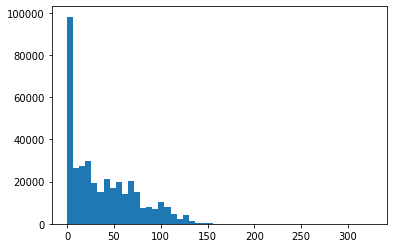

In [191]:
# приведение поля к типу integer
data['Year built'] = data['Year built'].astype('int')
data['Remodeled year'] = data['Remodeled year'].astype('int')
# Выполняем перекодировку полей в формат "Возраст дома. Количество лет" с учетом максимального года = 2025
max_date = 2025
data['Year built'] = data['Year built'].apply(lambda x: max_date-x if x > 0 else x)
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: max_date-x if x > 0 else x)
# проверяем распределение
plt.hist(data['Year built'], bins=50);

Распределение имеет экспоненциальный характер. Требуется логарифмирование признаков

In [192]:
data['year_built_log'] = np.log(data['Year built']+1)
data['remodeled_year_log'] = np.log(data['Remodeled year']+1)

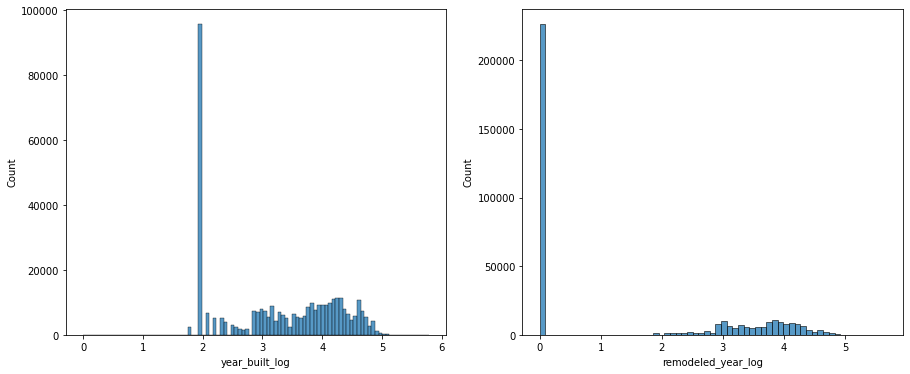

In [193]:
# визуализация распределений признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
hist1 = sns.histplot(data=data['year_built_log'], ax = axes[0])
hist2 = sns.histplot(data=data['remodeled_year_log'], ax = axes[1])

### Кодировка полей Heating, Cooling

In [194]:
# заполняем пропуски в новых признаках заглушками и приводим к упорядоченной структуре
data['Heating'] = data['Heating'].fillna('no_data')
data['Cooling'] = data['Cooling'].fillna('no_data')
data['Parking'] = data['Parking'].fillna('')
data['lotsize'] = data['lotsize'].fillna('no_data')
data['Price/sqft'] = data['Price/sqft'].fillna('no_data')
# символы переводим в нижний регистр
data['Heating'] = data['Heating'].apply(lambda x: str.lower(x))
data['Cooling'] = data['Cooling'].apply(lambda x: str.lower(x))
data['Parking'] = data['Parking'].apply(lambda x: str.lower(x))
# типизация пропусков
data['Heating'] = data['Heating'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Cooling'] = data['Cooling'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Parking'] = data['Parking'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)

In [195]:
# исследуем распределение признака
data['Heating'].value_counts().head(15)

Heating
no_data                  147597
forced air               134308
electric                  10216
gas                        9296
heat pump                  8851
central air                7814
central electric           7112
central                    6247
central, electric          4253
baseboard                  3815
wall                       3301
electric heat              3064
heating system             2709
forced air, heat pump      1767
radiant                    1485
Name: count, dtype: int64

In [196]:
data['Cooling'].value_counts().head(15)

Cooling
central                                            158744
no_data                                            143774
central air                                         14384
has cooling                                          9730
central electric                                     6154
wall                                                 4017
central gas                                          3573
central heating                                      2807
cooling system                                       2700
central a/c                                          2051
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
refrigeration                                        1075
central, electric                                    1060
electric                                             1012
Name: count, dtype: int64

In [197]:
# Анализ структуры данных показывает, что сведения об отоплении и кондиционировании содержатся в обоих полях.
data['Heat_Cool'] = data['Heating'] + ' // ' + data['Cooling'] # объединяем поля в одно и обрабатываем по ключевым фразам
# Heating and Cooling hand-coding
data['heating_1'] = data['Heat_Cool'].apply(lambda x: 1 if 'forced air' in x else 0).astype('int')
data['heating_2'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x else 0).astype('int')
data['heating_3'] = data['Heat_Cool'].apply(lambda x: 1 if 'gas' in x else 0).astype('int')
data['heating_4'] = data['Heat_Cool'].apply(lambda x: 1 if 'central' in x 
                                            or 'heating system' in x 
                                            or 'has heating' in x else 0).astype('int')
data['heating_5'] = data['Heat_Cool'].apply(lambda x: 1 if 'radiant' in x else 0).astype('int')
data['heating_6'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x or 'A/C' in x or 'AC' in x else 0).astype('int')
data['heating_7'] = data['Heat_Cool'].apply(lambda x: 1 if 'baseboard' in x or 'wall' in x else 0).astype('int')
data['heating_8'] = data['Heat_Cool'].apply(lambda x: 1 if 'heat pump' in x else 0).astype('int')
data['heating_9'] = data['Heat_Cool'].apply(lambda x: 1 if 'oil' in x else 0).astype('int')
data['heating_10'] = data['Heat_Cool'].apply(lambda x: 1 if 'solar' in x else 0).astype('int')
data['heating_11'] = data['Heat_Cool'].apply(lambda x: 1 if 'zoned' in x else 0).astype('int')
#
# Cooling coding
data['cooling'] = data['Heat_Cool'].apply(lambda x: 1 if 'has cooling' in x 
                                          or 'cooling system' in x 
                                          or 'refrigeration' in x 
                                          or 'evaporative' in x 
                                          or 'window unit' in x 
                                          or 'evaporative' in x 
                                          or 'condition' in x else 0).astype('int')
#
data['ceiling_fan'] = data['Heat_Cool'].apply(lambda x: 1 if 'ceiling fan' in x else 0).astype('int')
data['Humidity'] = data['Heat_Cool'].apply(lambda x: 1 if 'humidity' in x else 0).astype('int')
# удаляем исходное поле
data = data.drop(labels=['Heating','Cooling'], axis=1)
# удаляем исходное поле
data = data.drop(labels=['Heat_Cool'], axis=1)

### Кодировка поля Parking

In [198]:
# изучаем структуру
data['Parking'].value_counts().head(15)

Parking
no_data                             187548
attached garage                      70748
2 spaces                             28061
1 space                              14252
detached garage                      13200
carport                               7743
off street                            5279
3 spaces                              4724
                                      3533
carport, attached garage              3025
1                                     2936
4 spaces                              2917
2                                     2756
on street                             1707
attached garage, detached garage      1354
Name: count, dtype: int64

Применяем ручное кодирование

In [199]:
# Heating and Cooling hand-coding
for i in range(9):
    field_name = 'parking_'+str(i+1)
    data[field_name] = data['Parking'].apply(lambda x: 1 if str(i) in x else 0).astype('int')
    
# Parking features hand-coding
data['parking_10'] = data['Parking'].apply(lambda x: 1 if 'garage' in x else 0).astype('int')
data['parking_11'] = data['Parking'].apply(lambda x: 1 if 'attached' in x else 0).astype('int')
data['parking_12'] = data['Parking'].apply(lambda x: 1 if 'detached' in x else 0).astype('int')
data['parking_13'] = data['Parking'].apply(lambda x: 1 if 'carport' in x else 0).astype('int')
data['parking_14'] = data['Parking'].apply(lambda x: 1 if 'off street' in x or 'front' in x or 'slab' in x else 0).astype('int')
data['parking_15'] = data['Parking'].apply(lambda x: 1 if 'on street' in x or 'driveway' in x else 0).astype('int')
data['parking_16'] = data['Parking'].apply(lambda x: 1 if 'door opener' in x else 0).astype('int')
data['parking_17'] = data['Parking'].apply(lambda x: 1 if 'entry' in x else 0).astype('int')
# удаляем исходное поле
data = data.drop(labels=['Parking'], axis=1)

### Обработка и очистка поля "Lot size" (площадь земельного участка)

In [200]:
# иучаем структуру данных поля
data['lotsize']

0             no_data
1           5828 sqft
2          8,626 sqft
3          8,220 sqft
4         10,019 sqft
             ...     
377130     8,500 sqft
377131           none
377132     1,600 sqft
377133        no_data
377134     6,969 sqft
Name: lotsize, Length: 377135, dtype: object

In [201]:
# типизация данных
data['lotsize'] = data['lotsize'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('sqft lot','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres lot','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq.Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq. Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('—','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('--','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acre','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acres','acre'))
# проверка наличия пропусков
data['lotsize'].isna().sum()

0

In [202]:
# вычленяем данные о единице измерения
data['lot_size'] = data['lotsize'].apply(lambda x: x.split()[0] ) # отделяем числовые данные от ед.измерения
data['mes_unit'] = data['lotsize'].apply(lambda x: x.split()[1] if len(x.split())>1 else 'no_data') # временный признак - единица измерения площади зем.участка
#
data['mes_unit'].value_counts()

mes_unit
sqft       163906
no_data    135939
acre        77290
Name: count, dtype: int64

Поле содержит данные в двух единицах измерения - кв.футы и акры. Переводим акры в кв.футы

In [203]:
# доп очистка данных
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace('no_data','0'))
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace(',',''))
data['lot_size'] = data['lot_size'].apply(lambda x: '0' if x == '' else x)
# приведение поля к типу float
data['lot_size'] = data['lot_size'].astype('float')
# приведение площади участка к квадратным футам
data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] = round(data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] * 43560)
# проверка на пропуски
data['lot_size'].isna().sum()

0

Обработаем выбросы

In [204]:
# определяем индекс записи с отрицательным значением поля Площадь участка
data[data['lot_size']<0].index

Index([292924], dtype='int64')

In [205]:
data[data['lot_size']>1e+7].shape

(205, 51)

Большинство выбросов - слишком большие значения. Удалим записи с площадями более 100Га, так как для них речь идет уже не о стоимости жилья, а о неких поместьях.

Одно отрицательное значение заполним нулем

In [206]:
#data.loc[outliers_z['lot_size'].index, 'lot_size'] = data['lot_size'].median()
# Удаляем строки со слишком большими площадями (>100 Га)
data = data.drop(labels=data[data['lot_size']>1e+7].index, axis=0)
# заполняем отрицательное значение нулем
data.loc[292924, 'lot_size'] = 0
data.shape

(376930, 51)

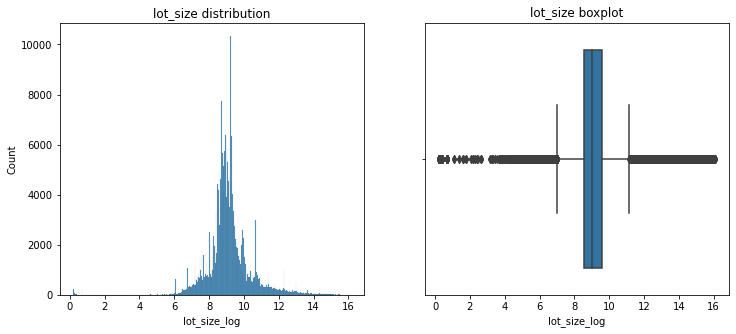

In [207]:
# логарифмируем распределение
data['lot_size_log'] = np.log(data['lot_size']+1)
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = data[data['lot_size_log']>0], x = 'lot_size_log', ax=axes[0])
histplot.set_title('lot_size distribution')
boxplot = sns.boxplot( data = data[data['lot_size_log']>0], x = 'lot_size_log', ax = axes[1])
boxplot.set_title('lot_size boxplot');

In [208]:
from scipy.stats import normaltest
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

In [209]:
_, p = normaltest(data['lot_size_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


In [210]:
# удаляем исходное поле
data = data.drop(labels=['mes_unit'], axis=1)
# удаляем исходное поле
data = data.drop(labels=['lotsize'], axis=1)

### Поле 'Price/sqft'

Сильно коррелирующее с целевой переменной поле - удалить

(теоретически из этого поля можно вытащить доп.данные для определения площади дома или наоборот - заполнения пропущенного целевого значения)

In [211]:
# удаляем исходное поле
data = data.drop(labels=['Price/sqft'], axis=1)

### Обработка поля target.

Преобразование типа целевой переменной и очистка выбросов целевой переменной

In [212]:
# удаляем строки с пустым target
data = data.dropna(axis=0, subset=['target'])

# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
specs_list = ['$',',',' ','+']

# функция обработки, удаление спецсимволов
def search_for_specs(arg):
    if '/mo' in arg: # похоже на стоимость помесячной аренды, помечаем эти записи nan для последующего удаления
        arg = np.nan
        return arg
    for symbol in arg:
        if symbol in specs_list:
            arg = arg.replace(symbol,'')
    return arg
# обрабатываем поле и преобразуем в тип float
data['target'] = data['target'].apply(search_for_specs).astype('float')

# удаляем новые строки с пустым target
data = data.dropna(axis=0, subset=['target'])
data.shape

(374053, 49)

Данные загрязнены выбросами. Необходима очистка выбросов

In [213]:
# Удаляем строки с заведомо низкой стоимостью (<1000)
data = data.drop(labels=data[data['target']<1000].index, axis=0)
data.shape

(373978, 49)

In [214]:
def outliers_iqr_mod(data, feature, log_scale=True, left_iqr=1.5, right_iqr=1.5):
    """
    Функция определения выбросов методом Тьюки
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left_iqr)
    upper_bound = quartile_3 + (iqr * right_iqr)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [215]:
outliers, cleaned = outliers_iqr_mod(data, 'target', 5, 5)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
# продолжаем работу с очищенными данными
data = cleaned

Число выбросов по методу Тьюки: 9280
Результирующее число записей: 364698


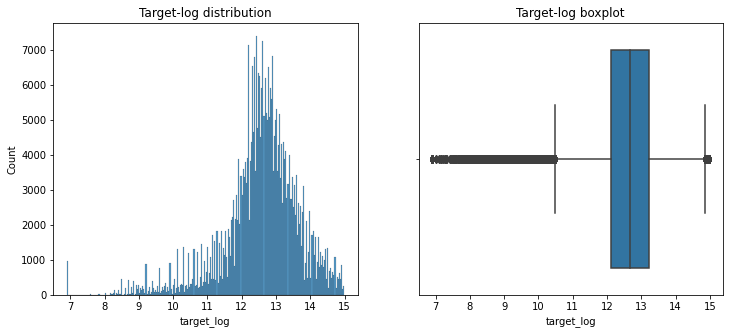

In [216]:
# прологарифмируем целевую переменную
data['target_log'] = np.log(data['target']+1)
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = data, x = 'target_log', ax=axes[0])
histplot.set_title('Target-log distribution')
boxplot = sns.boxplot( data = data, x = 'target_log', ax = axes[1])
boxplot.set_title('Target-log boxplot');

### Один из основных признаков для расчета стоимости жилья - площадь. Выполним преобразование типа этого признака и очистку выбросов

In [217]:
data['sqft']

0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
4                NaN
             ...    
377130         4,017
377131    2,000 sqft
377132    1,152 sqft
377133           NaN
377134         1,462
Name: sqft, Length: 364698, dtype: object

In [218]:
# удаляем строки с пустым sqft
data = data.dropna(subset=['sqft'], axis=0)
data.shape

(326593, 50)

In [219]:
# убираем фразы и спецсимволы, заданные списком
symbols_list = ['sqft','toalinerior','total','interior','livable','area',':','--',' ',',']

def search_for_symbols(arg):
    for sub_string in symbols_list:
        if sub_string in arg:
            arg = str.lower(arg).replace(sub_string,'')
    if arg == '':
        return np.nan
    return arg
# преобразуем в тип float
data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')
# удаляем строки с пустым sqft
data = data.dropna(subset=['sqft'], axis=0)
data.shape

C:\Users\Ustenko-S\AppData\Local\Temp\ipykernel_10660\994964204.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')


(325840, 50)

In [220]:
# Удаляем строки со слишком малой площадью (<10)
data = data.drop(labels=data[data['sqft']<10].index, axis=0)
data.shape

(314062, 50)

In [221]:
# функция определения выбросов методом 3х сигм
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [222]:
outliers_z, cleaned_z = outliers_z_score(data, 'sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_z.shape[0]}')
# продолжаем работу с очищенными данными (cleaned - метод тьюки, cleaned_z - метод 3-х сигм)
#data = cleaned
data = cleaned_z
data.shape

Число выбросов по методу z-отклонения: 2129
Результирующее число записей: 311933


(311933, 50)

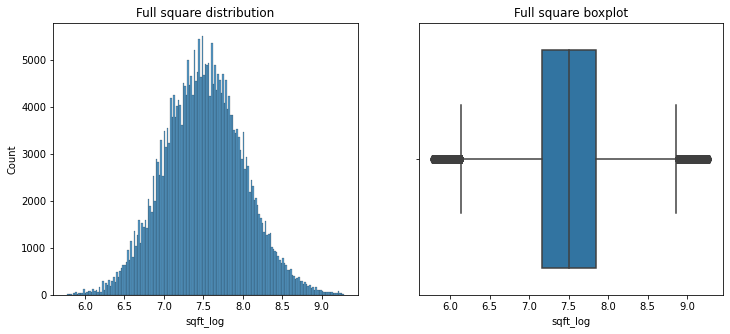

In [223]:
# логарифмируем распределение
data['sqft_log'] = np.log(data['sqft']+1)
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned_z, x = 'sqft_log', ax=axes[0])
histplot.set_title('Full square distribution')
boxplot = sns.boxplot( data = cleaned_z, x = 'sqft_log', ax = axes[1])
boxplot.set_title('Full square boxplot');

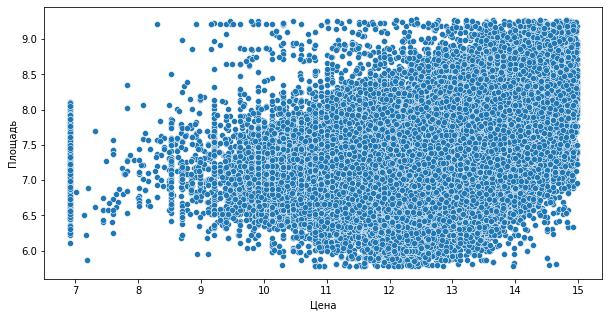

In [224]:
# оценим визуально зависимость цены недвижимости от площади 
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=data['target_log'], y=data['sqft_log'], ax=ax)
ax.set_xlabel('Цена')
ax.set_ylabel('Площадь');

Явной зависимости цены недвижимости от площади не прослеживается. Потребуется использование комплекса признаков для построения модели.

Необходимо сгенерировать больше признаков для модели

In [225]:
# удаляем поле с логарифмом
data = data.drop(labels=['target_log'], axis=1)

### Кодируем поле наличия бассейна

In [226]:
# изучаем структуру данных
data['PrivatePool'].value_counts()

PrivatePool
yes    26366
Yes    10279
Name: count, dtype: int64

In [227]:
# изучаем структуру данных 2-го поля
data['private pool'].value_counts()

private pool
Yes    3987
Name: count, dtype: int64

In [228]:
# определяем функцию для обработки полей
def pool_detect(arg1, arg2):
    #print(type(arg))
    if type(arg1) == str:
        if str.lower(arg1) == 'yes':
            return 1
    elif type(arg2) == str:
        if str.lower(arg2) == 'yes':
            return 1
    else:
        return 0

# кодируем поле по признаку наличия бассейна
data['pool'] = data[['private pool','PrivatePool']].apply(lambda x: pool_detect(*x), axis=1).astype('int')
data['pool'].value_counts()

pool
0    271301
1     40632
Name: count, dtype: int64

In [229]:
# удалим исходные поля
data = data.drop(labels=['private pool','PrivatePool'], axis=1)

### Кодируем "статус"

In [230]:
# изучаем значения поля статус и определяем основные признаки для кодирования
data['status'].value_counts().head(25)

status
for sale                             131893
Active                                76676
For sale                              40978
foreclosure                            5463
New construction                       5245
Pending                                4113
Pre-foreclosure                        1557
P                                      1439
Under Contract Show                    1062
Pre-foreclosure / auction               978
 / auction                              792
Under Contract   Showing                745
Active Under Contract                   689
Under Contract                          650
Contingent                              518
New                                     480
Price Change                            455
A Active                                376
Auction                                 366
Foreclosure                             295
Foreclosed                              251
Under Contract Backups                  249
Contingent Finance And In

Признаки пересекаются, необходимо применить ручное кодирование

In [231]:
data['status'].isna().sum()

35011

In [232]:
# заполняем пропуски заглушкой
data['status'] = data['status'].fillna('no_data')
# переводим текстовое поле в нижний регистр
data['status'] = data['status'].apply(lambda x: str.lower(x))

# унифицируем ключевые фразы
data['status'] = data['status'].apply(lambda x: 'rental' if 'for rent' in x else x)
data['status'] = data['status'].apply(lambda x: 'active' if x == 'a active' or 'coming soon' in x else x)
data['status'] = data['status'].apply(lambda x: 'reactivated' if x == 're activated' or x == 'back on market' else x)
# проверить ????
data['status'] = data['status'].apply(lambda x: 'active backup' if x == 'backup contract' or x == 'backup' or x == 'active backup' else x)
#
data['status'] = data['status'].apply(lambda x: 'active contingent' if 'active' in x and 'contingen' in x else x)
data['status'] = data['status'].apply(lambda x: 'active option' if 'active option contract' in x else x)
#
#data['status'] = data['status'].apply(lambda x: 'pending taking backups' if x == 'pending - taking backups' else x)
data['status'] = data['status'].apply(lambda x: 'contract pending' if x == 'contract p' else x)
data['status'] = data['status'].apply(lambda x: 'pending backup' if 'pending' in x and 'backup' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending contingency' if 'pending' in x and 'cont' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending inspection' if x == 'p' 
                                      or x == 'pi' 
                                      or x == 'pending' 
                                      or x == 'pending in' 
                                      or x == 'pending inspection'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending continue_to_show' if x == 'ct'
                                      or ('pending' in x and 'continue' in x and 'show' in x)
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending' if x == 'pending sale'
                                      or x == 'p pending sale'
                                      or x == 'pending sh'
                                      or x == 'ps'
                                      or x == 'pf'
                                      or ('pending' in x and 'not' in x and 'show' in x)
                                      else x)

data['status'] = data['status'].apply(lambda x: 'pre-foreclosure' if x == 'pre-foreclosure / auction' else x)
data['status'] = data['status'].apply(lambda x: 'under contract' 
                                      if x == 'under contract   showing' 
                                      or x == 'under contract show' 
                                      or x == 'active under contract' 
                                      or x == 'under contract - show' 
                                      or x == 'u under contract' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'contingency' if x == 'contingent show' 
                                      or x == 'c' 
                                      or x == 'contingency 48 hr (+/ )'
                                      or x == 'contingent   release'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'foreclosured' if x == 'foreclose' else x)
data['status'] = data['status'].apply(lambda x: 'auction' if x == ' / auction' 
                                      or x == 'auction - active' 
                                      or x == 'active - auction' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'new_construction' if x == 'new' or x == 'new construction' else x)
# 
data['status'] = data['status'].apply(lambda x: x.replace('bckp','backup').replace('back up','backup').replace('backups','backup'))
data['status'] = data['status'].apply(lambda x: x.replace('accepted','accept').replace('accpt','accept').replace('accepting','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('contingent','contingency').replace('accpt','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('offers','offer').replace('financing','finance'))
data['status'] = data['status'].apply(lambda x: x.replace('  ',' ').replace(' - ',' ').replace('with',''))
# Удаляем строки со статусом аренда
data = data.drop(labels=data[data['status']=='rental'].index, axis=0)
data.shape

(311929, 49)

In [233]:
# собираем словарь из ключевых фраз и закодируем поле статус по словарю для достаточно часто повторяющихся слов (>100 раз)
status_codes_dict = {}

def status_processing(arg):
    dict = arg.split(' ')
    for i in range(len(dict)):
        word = dict[i]
        if word in status_codes_dict:
            status_codes_dict[word] += 1
        elif len(dict[i])>3:
            status_codes_dict[word] = 1
    
            
data['status'].apply(status_processing);
# фильтруем словарь
status_codes_dict = dict(filter(lambda item: item[1] > 100, status_codes_dict.items()))
# сводим в список частых ключевых слов
status_codes_list = list(status_codes_dict.keys())
# создание новых бинарных признаков, проходим циклом по списку ключевых фраз
for i in range(len(status_codes_list)):
    field_name = 'status_'+str(i+1)
    data[field_name] = data['status'].apply(lambda x: 1 if status_codes_list[i] in x else 0).astype('int')

data.shape

(311929, 68)

===============================================

In [234]:
# удаляем исходное поле
data = data.drop(labels=['status'], axis=1)

### Для этажности есть отдельный признак. Кодируем количество этажей с учетом данных из поля PropertyType

In [235]:
data['stories'].value_counts().head(10)

stories
1.0    65496
2.0    53228
1      22323
2      17435
3.0    10383
0.0     6852
One     5731
0       4013
3       3937
9.0     2700
Name: count, dtype: int64

In [236]:
# заполняем пропуски заглушкой
data['stories'] = data['stories'].fillna('no_data')
# символы переводим в нижний регистр
data['stories'] = data['stories'].apply(lambda x: str.lower(x))
# унифицируем данные
data['stories'] = data['stories'].apply(lambda x: '1st' if x=='one' or x=='one story' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='two' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='three' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='quad' else x)
data['stories'] = data['stories'].apply(lambda x: '3+st' if x=='three or more' or x=='3+' or '3+ stories' in x else x)


data['stories'] = data['stories'].apply(lambda x: '1st' if x=='1' or x[:3]=='1.0' or x=='1 story' or x=='one story' or x=='1 level' or x=='one level' or x=='one-level' else x)
data['stories'] = data['stories'].apply(lambda x: '1.5st' if x=='1.5' or x[:3]=='1.5' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='2' or x[:3]=='2.0' or x=='2 story' or x=='2 stories' or x=='two story' or x=='2 level' or x=='bi-level' or x=='townhouse' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='3' or x[:3]=='3.0' or x=='3 story' or x=='3 stories' or x=='three story' or x=='3 level' or x=='tri-level' or x=='t3' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='4' or x[:3]=='4.0' or x=='4 story' or x=='4 stories' or x=='4 level' or x=='quad level' else x)
data['stories'] = data['stories'].apply(lambda x: '5st' if x=='5' or x[:3]=='5.0' or x=='5 story' or x=='5 level' else x)
data['stories'] = data['stories'].apply(lambda x: '6st' if x=='6' or x[:3]=='6.0' or x=='6 story' or x=='6 level' else x)
data['stories'] = data['stories'].apply(lambda x: '7st' if x=='7' or x[:3]=='7.0' or x=='7 story' or x=='7 level' else x)
data['stories'] = data['stories'].apply(lambda x: '8st' if x=='8' or x[:3]=='8.0' or x=='8 story' or x=='8 level' else x)
data['stories'] = data['stories'].apply(lambda x: '9st' if x=='9' or x[:3]=='9.0' or x=='9 story' or x=='9 level' else x)
#
data['stories'] = data['stories'].apply(lambda x: '1st/'+x if 'one' in x or '1 story' in x or '1 level' in x or 'one level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '2st/'+x if 'two' in x or '2 stories' in x or '2 story' in x or '2 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '3st/'+x if 'three' in x or '3 stories' in x or '3 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '4st/'+x if 'quad' in x or '4 stories' in x or '4 level' in x else x)
#
data['stories'] = data['stories'].apply(lambda x: '' if x=='0' or x=='0.0' else x)
data['stories'] = data['stories'].apply(lambda x: '' if x=='no_data' else x)
#
data['stories'].value_counts().head(25)

stories
                           106545
1st                         96764
2st                         78613
3st                         15105
9st                          3134
4st                          2791
3+st                         1333
1.5st                        1197
6st                           777
5st                           651
7st                           325
8st                           303
1st/ranch/1 story             291
2st/two story or more         251
multi/split                   240
2st/2 level, site built       192
condominium                   168
1st/1 level, site built       155
2st/2 story/basement          150
stories/levels                131
ranch                         127
traditional                    87
2.50                           83
1st/1 story basement           82
mid-rise                       78
Name: count, dtype: int64

In [237]:
# создаем новые признаки для основных типов этажности
data['1_story'] = data['stories'].apply(lambda x: 1 if '1st' in x or x == '' else 0).astype('int')
data['1h_story'] = data['stories'].apply(lambda x: 1 if x=='1.5' or x[:3]=='1.5' else 0)
data['2_story'] = data['stories'].apply(lambda x: 1 if '2st' in x else 0).astype('int')
data['3_story'] = data['stories'].apply(lambda x: 1 if '3st' in x else 0).astype('int')
data['3m_story'] = data['stories'].apply(lambda x: 1 if '3+st' in x else 0).astype('int')
data['4_story'] = data['stories'].apply(lambda x: 1 if '4st' in x else 0).astype('int')
data['5_story'] = data['stories'].apply(lambda x: 1 if '5st' in x else 0).astype('int')
data['6_story'] = data['stories'].apply(lambda x: 1 if '6st' in x else 0).astype('int')
data['7_story'] = data['stories'].apply(lambda x: 1 if '7st' in x else 0).astype('int')
data['8_story'] = data['stories'].apply(lambda x: 1 if '8st' in x else 0).astype('int')

Идеи для дальнейшей обработки: можно еще слить поля stories и propertyType так как в них много общих данных

In [238]:
# удаляем исходное поле
data = data.drop(labels=['stories'], axis=1)

### Кодируем тип недвижимости "propertyType"

In [239]:
# исследуем структуру данных поля
data['propertyType'].value_counts().head(10)

propertyType
single-family home               88464
Single Family                    58876
Single Family Home               30816
condo                            23962
Condo                            15510
townhouse                        11014
Condo/Townhome/Row Home/Co-Op     7499
multi-family                      6905
Townhouse                         6659
Traditional                       5820
Name: count, dtype: int64

Здесь также лучше подойдет ручное кодирование

In [240]:
# заполняем пропуски заглушкой
data['propertyType'] = data['propertyType'].fillna('unknown')
# символы переводим в нижний регистр
data['propertyType'] = data['propertyType'].apply(lambda x: str.lower(x))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if x == ' ' else x)
# унификация данных
#data['propertyType'] = data['propertyType'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('one story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('1 story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 stories','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('two story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bilevel','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 levels','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('tri-level','3st'))
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'tri-level' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'less than 4 floors' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bi-level ','split'))
#data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('split-level','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('midcentury','mid century').replace('midcentury','mid-century'))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'other' in x or x == 'miscellaneous' or x == 'custom' or x == '' or x == ' ' else x)

In [241]:
extra_data_status = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
status_codes = [['single','family','detached','tiny home'],
                '1st','2st','3st',
                'condo','town','tradition','craftsman','cottage','high','federal','tudor','loft','split-entry',
                'split','basement','penthouse','historic','fourplex','mid-rise','duplex','french','elevated','a-frame',
                'bungalow','coastal',
                ['flat','apartment'],
                ['mid-rise','3+ stories'],
                ['beaux arts','art deco'],
                ['mediterran','spanish'],
                ['colonial','georgian','charleston'],
                ['english','victorian'],
                ['santa barbara','tuscan'],
                ['multi','cluster'],
                ['florida','cape','key west'],
                ['contemp','modern'],
                ['ranch','farm'],
                ['coop','co-op'],
                ['mobile','carriage'],
                ['manufactur','prefab','modular']]
# создание новых бинарных признаков проходим циклом по списку ключевых фраз
for i in range(len(status_codes)):
    if type(status_codes[i])==list and len(status_codes[i]) == 2:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 3:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x or status_codes[i][2] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 4:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x 
                                                      or status_codes[i][1] in x 
                                                      or status_codes[i][2] in x 
                                                      or status_codes[i][3] in x else 0).astype('int')
    else:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i] in x else 0).astype('int')
# считаем количество новых признаков
len(status_codes)

40

In [242]:
# тип земля или съемная квартира - помечаем на удаление
extra_data_status['type_lot'] = data['propertyType'].apply(lambda x: 1 if 'lot' in x or 'land' in x else 0).astype('int')
# склеиваем датафреймы
data = pd.concat([data, extra_data_status], axis=1)
# удаляем исходное поле
data = data.drop(labels=['propertyType'], axis=1)
# Удаляем строки с типом "земельный участок"
data = data.drop(labels=data[data['type_lot']==1].index, axis=0)
data.shape

(308371, 116)

In [243]:
# удаляем исходное поле "земельный участок"
data = data.drop(labels=['type_lot'], axis=1)

### Кодируем количество спален

In [244]:
data['beds']

0              4
1         3 Beds
2         3 Beds
3         5 Beds
5         2 Beds
           ...  
377129         2
377130         5
377131    3 Beds
377132    3 Beds
377134         3
Name: beds, Length: 308371, dtype: object

In [245]:
data['beds'].isna().sum()

45001

In [246]:
# заполняем пропуски заглушкой - нулем.
data['beds'] = data['beds'].fillna('0')
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['beds',' ','bd','--']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if 'sqft' in str.lower(arg) or 'bath' in str.lower(arg) or 'price' in str.lower(arg):
        return 1
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['beds'] = data['beds'].apply(search_for_symbols).astype('float').astype('int')

### Кодируем количество ванных комнат

In [247]:
data['baths']

0             3.5
1         3 Baths
2         2 Baths
3         8 Baths
5             NaN
           ...   
377129          3
377130        6.0
377131    3 Baths
377132    3 Baths
377134        2.0
Name: baths, Length: 308371, dtype: object

In [248]:
# заполняем пропуски заглушкой
data['baths'] = data['baths'].fillna('0')
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['baths',' ','bathrooms:','ba','~','+','/','sq.ft.','-','semimod','—']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if ',' in str.lower(arg):
        arg = str.lower(arg).replace(',','.')
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип целый
data['baths'] = data['baths'].apply(search_for_symbols).astype('float').astype('int')

Поле "кол-во ванных комнат" содержит странные числа. Все что больше 10 приравниваем 1

In [249]:
# заменяем странные значения на 1
data['baths'] = data['baths'].apply(lambda x: 1 if x > 20 else x)
data['baths'].value_counts()

baths
2     116129
3      70636
0      55922
4      26338
1      24857
5       8727
6       3416
7       1317
8        598
9        150
10        92
12        64
11        53
13        28
16        13
14        11
18         8
20         6
15         5
19         1
Name: count, dtype: int64

### Кодируем количество каминов

In [250]:
data['fireplace'].value_counts().head(10)

fireplace
yes               46705
Yes               19654
1                 13912
2                  2184
Not Applicable     1983
Fireplace           827
3                   427
Living Room         394
Wood Burning        303
Gas/Gas Logs        296
Name: count, dtype: int64

In [251]:
# заполняем пропуски заглушкой
data['fireplace'] = data['fireplace'].fillna('0')
# символы переводим в нижний регистр
data['fireplace'] = data['fireplace'].apply(lambda x: str.lower(x))

In [252]:
extra_data = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
fireplace_keys = ['gas','closet','electric','storage','extra','utility connection',
                  ['logs','wood'],
                  ['brick','masonry']]
# создание новых бинарных признаков
for i in range(len(fireplace_keys)):
    if type(fireplace_keys[i])==list and len(fireplace_keys[i]) == 2:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i][0] in x or fireplace_keys[i][1] in x else 0).astype('int')
    else:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i] in x else 0).astype('int')

In [253]:
# кодируем поле по количеству каминов
fireplace_yes_words = ['gas','wood','family','features','room','den','firepit']
#fireplace_no_words = ['decorative', 'n/k', 'not app', 'fireplace yn', 'electric', 'no fireplace']

def search_for_words(arg):
    if arg == 'yes' or arg == 'fireplace' or '1' in arg or 'one' in arg:
        return 1
    elif 'two' in arg or '2' in arg:
        return 2
    elif '3' in arg:
        return 3
    else:
        for word in fireplace_yes_words:
            if word in arg:
                return 1
        return 0

# 
data['fireplace'] = data['fireplace'].apply(search_for_words).astype('int')
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)
data.shape

(308371, 123)

### Распаковываем поле Scools

In [254]:
# перестраиваем индекс и далее работаем с копией датасета с новым индексом
data_reset = data.reset_index()

In [255]:
# распаковка поля schools и извлечение новых признаков
schools_list_1 = list() # создаем пустой список для словарей
schools_list_2 = list() # создаем пустой список для словарей
# создаем новый датафрейм для обработки школьных данных
extra_data = pd.DataFrame(data_reset['schools'])

def schools_unpack(arg): # функция распаковки поля schools
    schools_list_1.append(eval(arg)[0])
    schools_list_2.append(eval(arg)[0]['data'])
    
# обрабатываем поле функцией
data_reset['schools'].apply(schools_unpack);
# преобразуем списки словарей в датафреймы
extra_data_1 = pd.DataFrame(schools_list_1)
extra_data_2 = pd.DataFrame(schools_list_2)
# склеиваем датафреймы
extra_data = pd.concat([extra_data, extra_data_1], axis=1)
extra_data = pd.concat([extra_data, extra_data_2], axis=1)
# новые признаки
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308371 entries, 0 to 308370
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   schools   308371 non-null  object
 1   rating    308371 non-null  object
 2   data      308371 non-null  object
 3   name      308371 non-null  object
 4   Distance  308371 non-null  object
 5   Grades    308371 non-null  object
dtypes: object(6)
memory usage: 14.1+ MB


Можно посчитать количество школ в окрестности объекта, средний рейтинг школ, среднюю дистанцию по трем новым признакам

### Обработка поля schools

In [256]:
# Определяем новый признак - количество школ в округе
extra_data['school_count'] = extra_data['name'].apply(lambda x: len(x)).astype('int')

### Определяем новые признаки из расстояний до школ

In [257]:
def school_distance_avg(arg):
    """функция рассчета среднего расстояния до школ

    Args:
        arg (list): список из чисел с обозначением mi

    Returns:
        float: средний рейтинг
    """
    n = 0
    if len(arg) > 0: # если список не пустой
        for i in arg: # цикл по списку
            i = re.sub(r'[a-zA-Z ]', '', i) # удаляем символы
            if i != '':
                n += float(i)
        return round(n / len(arg),1)
    else:
        return 0
    
def school_distance_min(arg):
    """ функция рассчета расстояния до ближайшей школы

    Args:
        arg (list): список из чисел с обозначением mi из поля Distance

    Returns:
        list: список из двух элементов: мин расстояние и номер школы
    """
    
    n = 999
    if len(arg) > 0: # если список не пустой
        counter = min_number = 0
        for i in arg: # цикл по списку
            i = re.sub(r'[a-zA-Z ]', '', i) # удаляем символы
            if i != '' and float(i) < n:
               min_number = counter
               n = float(i)
            counter += 1
        return [min_number, n]
    else:
        return [0, 999]
# добавляем новые признаки
extra_data['school_distance_min'] = extra_data['Distance'].apply(school_distance_min) # расстояние до ближайшей школы
extra_data['school_distance_avg'] = extra_data['Distance'].apply(school_distance_avg) # среднее расстояние до школ

### "Средний рейтинг школ в округе"

In [258]:
def rating_processing(arg):
    """ функция обработки рейтингов школ

    Args:
        arg (list): список из чисел из поля rating, содержащий спецсимволы

    Returns:
        list: очищенный список из чисел
    """
    if len(arg) > 0:
        for i in range(len(arg)):
            arg[i] = re.sub(r'[a-zA-Z/10]', '', arg[i])
        return arg
    else:
        return arg

extra_data['school_rating'] = extra_data['rating'].apply(rating_processing) # рейтинги школ

In [259]:
extra_data['school_rating']

0         [4, 4, 7, , 4, 7, , ]
1                      [4, , 4]
2                     [8, 4, 8]
3                   [9, 9, , 9]
4                            []
                  ...          
308366                   [3, 3]
308367                    [, 5]
308368                 [, 5, 7]
308369                   [5, 4]
308370                [5, 4, 3]
Name: school_rating, Length: 308371, dtype: object

In [260]:
def rating_processing(arg):
    """ функция рассчета среднего рейтинга школ

    Args:
        arg (list): список из чисел из поля rating, содержащий спецсимволы
    """
    n = 0
    if len(arg) > 0:
        for i in arg:
            if i != '':
                n += int(i)
        return round(n / len(arg),1)
    else:
        return 0

extra_data['school_rating_avg'] = extra_data['school_rating'].apply(rating_processing) # усредненный рейтинг школ

### Рейтинг ближайшей школы

In [261]:
# определяем ближайшую школу
extra_data['school_nearest'] = extra_data['school_distance_min'].apply(lambda x: x[0])
def rating_nearest_school(x, y):
    if len(x)>0:
        return x[y]
    else:
        return 0

# создаем новые признаки - рейтинг и расстояние до ближайшей школы
extra_data['school_rating_prx'] = extra_data.apply(lambda row: rating_nearest_school(row['school_rating'],row['school_nearest']), axis=1)
extra_data['school_distance_min'] = extra_data['school_distance_min'].apply(lambda x: x[1])

Обработаем пропуски. Заполним средним значением пропуски в поле 'school_distance_min'

In [262]:
extra_data['school_rating_prx'].value_counts()

school_rating_prx
4    41170
     40289
5    39294
3    39229
6    35875
7    33050
2    30426
8    27689
9    18990
0     2359
Name: count, dtype: int64

In [263]:
extra_data.loc[extra_data[extra_data['school_rating_prx']==''].index, 'school_rating_prx'] = np.nan
extra_data['school_rating_prx'] = extra_data['school_rating_prx'].astype('float')
# обрабатываем странные значения Year built, пропускам присваиваем NaN
extra_data.loc[extra_data[extra_data['school_distance_min']==999].index, 'school_distance_min'] = np.nan
extra_data.loc[extra_data[extra_data['school_distance_min']==0].index, 'school_distance_min'] = np.nan
extra_data.loc[extra_data[extra_data['school_distance_avg']==0].index, 'school_distance_avg'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_avg']==0].index, 'school_rating_avg'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_prx']==''].index, 'school_rating_prx'] = np.nan
extra_data.loc[extra_data[extra_data['school_rating_prx']==0].index, 'school_rating_prx'] = np.nan
extra_data['school_distance_min'].isna().sum()

2879

In [264]:
extra_data = extra_data.fillna({
    'school_distance_min': round(extra_data['school_distance_min'].mean(),1),
    'school_distance_avg': round(extra_data['school_distance_avg'].mean(),1),
    'school_rating_avg': round(extra_data['school_rating_avg'].mean(),1),
    'school_rating_prx': round(extra_data['school_rating_prx'].mean(),1)
    } )
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308371 entries, 0 to 308370
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   schools              308371 non-null  object 
 1   rating               308371 non-null  object 
 2   data                 308371 non-null  object 
 3   name                 308371 non-null  object 
 4   Distance             308371 non-null  object 
 5   Grades               308371 non-null  object 
 6   school_count         308371 non-null  int32  
 7   school_distance_min  308371 non-null  float64
 8   school_distance_avg  308371 non-null  float64
 9   school_rating        308371 non-null  object 
 10  school_rating_avg    308371 non-null  float64
 11  school_nearest       308371 non-null  int64  
 12  school_rating_prx    308371 non-null  float64
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 29.4+ MB


In [265]:
# удаляем исходные столбцы
data_reset.drop(labels=['schools','index'], axis=1, inplace=True)
# удаляем исходный столбец
extra_data.drop(labels=['name','rating','data','Grades','Distance','schools','school_rating','school_nearest'], axis=1, inplace=True)

In [266]:
# склеиваем датафреймы
data_reset = pd.concat([data_reset, extra_data], axis=1)
data_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308371 entries, 0 to 308370
Columns: 127 entries, baths to school_rating_prx
dtypes: float64(11), int32(112), int64(4)
memory usage: 167.0 MB


Выгружаем подготовленный датасет в файл

In [267]:
# выгрузка данных в файл
data_reset.to_csv("./data/data_prepared.csv", sep=',', index=False)